<a href="https://www.kaggle.com/code/utkarshx27/credit-card-fraud-detection?scriptVersionId=136084869" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="padding: 40px;color:white;margin:10;font-size:90%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Credit Card Fraud Detection</span></b> </div>
***

## Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [1]:
import numpy as np
import pandas as pd 

from matplotlib import pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve


In [2]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['missing'] = df.isnull().sum().values
    summ['missing[%]'] = df.isnull().sum().values / len(df) * 100
    summ['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['median'] = df.median().values
    summ['std'] = df.std().values

    numeric_columns = df.select_dtypes(include=np.number).columns
    for col in numeric_columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        summ.loc[col, 'outliers'] = outliers.count()
        summ.loc[col, 'lower_bound'] = lower_bound
        summ.loc[col, 'upper_bound'] = upper_bound

    return summ

summary(df)

data shape: (284807, 31)


,data type,missing,missing[%],unique,min,max,median,std,outliers,lower_bound,upper_bound
Time,float64,0,0.0,124592,0.000000,172792.000000,84692.000000,47488.145955,0.0,-73477.000000,266999.000000
V1,float64,0,0.0,275663,-56.407510,2.454930,0.018109,1.958696,7062.0,-4.274396,4.669664
V2,float64,0,0.0,275663,-72.715728,22.057729,0.065486,1.651309,13526.0,-2.701961,2.907135
V3,float64,0,0.0,275663,-48.325589,9.382558,0.179846,1.516255,3363.0,-3.766705,3.903536
V4,float64,0,0.0,275663,-5.683171,16.875344,-0.019847,1.415869,11148.0,-3.236612,3.131313
V5,float64,0,0.0,275663,-113.743307,34.801666,-0.054336,1.380247,12295.0,-2.646882,2.567212
V6,float64,0,0.0,275663,-26.160506,73.301626,-0.274187,1.332271,22965.0,-2.518586,2.148856
V7,float64,0,0.0,275663,-43.557242,120.589494,0.040103,1.237094,8948.0,-2.240844,2.257204
V8,float64,0,0.0,275663,-73.216718,20.007208,0.022358,1.194353,24134.0,-1.012593,1.131309
V9,float64,0,0.0,275663,-13.434066,15.594995,-0.051429,1.098632,8283.0,-2.503452,2.457494


## Observations about the Credit Card Fraud Detection dataset:

- Data Shape: The dataset contains 284,807 rows and 31 columns, indicating a relatively large dataset with a significant amount of information.

- Data Types: The dataset consists mostly of numerical features, represented by float64 data type, except for the 'Class' column, which is of type int64, likely representing the target variable.

- Missing Values: There are no missing values in the dataset as indicated by the 'missing' column, which shows zero missing values for all features.

- Unique Values: The 'unique' column provides the count of unique values for each feature. It appears that most of the numerical features have a large number of unique values, suggesting a wide range of potential values and potentially continuous variables.

- Descriptive Statistics: The 'min,' 'max,' 'median,' and 'std' columns present descriptive statistics for each feature. These statistics provide insights into the range, central tendency, and spread of the data.

- Outliers: The 'outliers' column indicates the number of outliers for each numeric feature. Outliers are determined using the interquartile range (IQR) method, where values beyond 1.5 times the IQR from the first and third quartiles are considered outliers. The count of outliers for each feature is displayed.

- Lower and Upper Bounds: The 'lower_bound' and 'upper_bound' columns represent the lower and upper bounds, respectively, for outlier detection. Any values below the lower bound or above the upper bound are considered potential outliers.

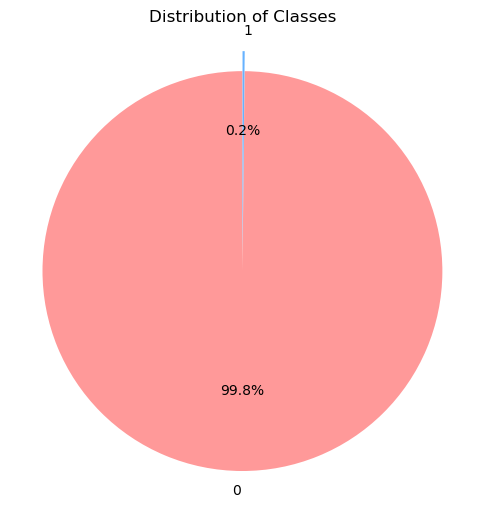

In [4]:
colors = ['#FF9999', '#66B2FF', '#99FF99']
class_counts = df['Class'].value_counts()
class_labels = class_counts.index.tolist()
explode = [0.05] * len(class_labels)
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
plt.title('Distribution of Classes')
plt.ylabel('')
plt.axis('equal')
plt.show()

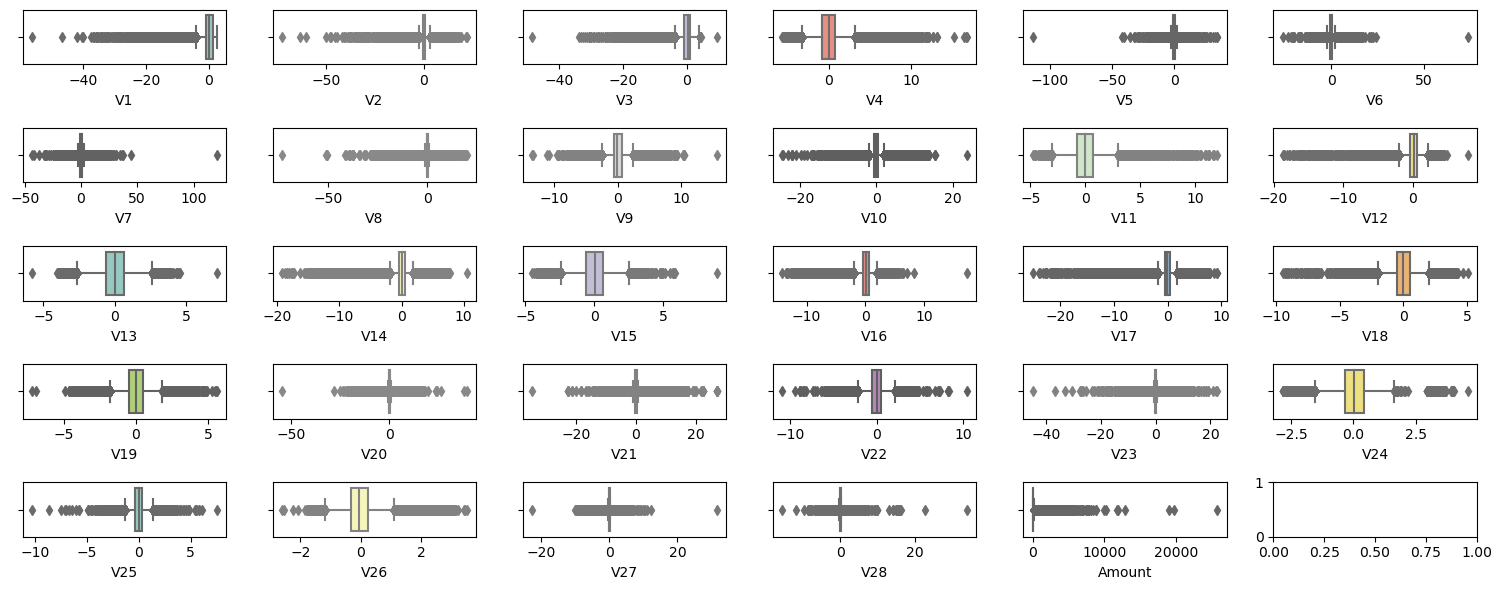

In [5]:
def boxplots(df):
    cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
    n = (len(cols) - 1) // 6 + 1
    m = min(len(cols), 6)

    palette = sns.color_palette("Set3", len(cols))
    palette_colors = [tuple(palette[i]) for i in range(len(cols))]

    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15, 6))
    axes = axes.flatten()

    for idx, col in enumerate(cols):
        sns.boxplot(data=df, x=col, ax=axes[idx], palette=[palette_colors[idx]])

    plt.tight_layout()
    plt.show()

boxplots(df)

In [6]:
X_df = df.drop('Class', axis=1)
y_df = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, stratify = y_df)

## Applying SMOTE 
SMOTE is a widely-used technique to tackle class imbalance. It works by creating synthetic samples of the minority class to increase its representation in the dataset. This helps balance the classes and improve the model's ability to learn from the minority class.


In [7]:
u = SMOTE(random_state=2, sampling_strategy = 0.5)
X, y = u.fit_resample(X_train, y_train)
y.shape, X.shape

((319854,), (319854, 30))

 ## DMatrix
DMatrix objects are the native data structure used by XGBoost for efficient training and prediction.

In [8]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## Baseline Model (Xgb)

In [9]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42
}
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)
y_pred = xgb_model.predict(dtest)

## Evaluation 

In [10]:
accuracy = accuracy_score(y_test, y_pred.round())
balanced_accuracy = balanced_accuracy_score(y_test, y_pred.round())
f1 = f1_score(y_test, y_pred.round())
precision = precision_score(y_test, y_pred.round())
recall = recall_score(y_test, y_pred.round())
roc_auc = roc_auc_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_pred)

print('Evaluation Metrics:')
print('Accuracy:', accuracy)
print('Balanced Accuracy:', balanced_accuracy)
print('F1 Score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print('ROC AUC Score:', roc_auc)
print('PR AUC Score:', pr_auc)

Evaluation Metrics:
Accuracy: 0.9995786635206876
Balanced Accuracy: 0.9064548240552679
F1 Score: 0.8695652173913043
Precision: 0.9345794392523364
Recall: 0.8130081300813008
ROC AUC Score: 0.9820407088551535
PR AUC Score: 0.8508717779234681


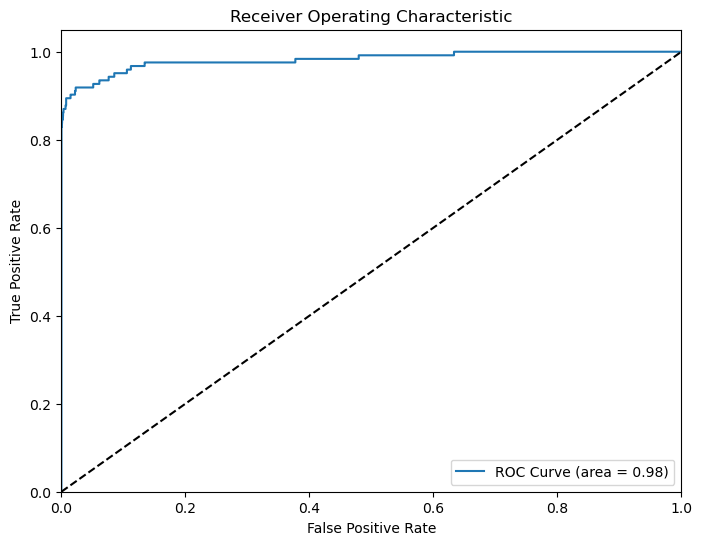

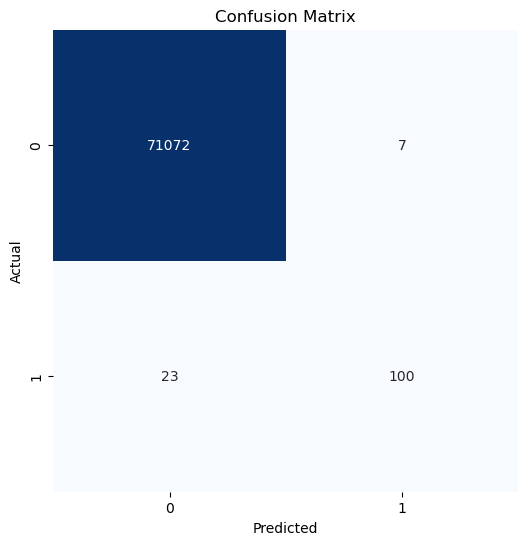

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, y_pred.round())
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()